y = Theta

x = time
 
z = omega(angular velocity)

a = acceleration

g(x,y) is the derivative dy/dx

h is the stepsize

f_i is the value of y(x_i), so

f_ipo is the value of y(x_ipo).

## We import

In [17]:
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

from matplotlib import animation, rc
from IPython.display import HTML

## Defining our coupled derivatives to integrate

In [18]:
def dydx(x, y):
    
    # Set the derivatives
    
    # Our equation is d^2y/dx^2 = -A*sin(y)-B*z+C*sin(D*x)
    
    # So we can write
    #z = dydx
    #dzdx = -A*sin(y)-B*z+C*sin(D*x) = a
    
    # We will set a = y[0]
    # we will set z = y[1]
    
    # Declare an array
    y_derivs = np.zeros(2)
    
    # Set dydx = z
    y_derivs[0] = y[1]
    
    # Set dy^2dx^2 = a
    y_derivs[1] = -1*np.sin(y[0]) -0.5*y[1] + 1.46*np.sin((2/3)*x)
    
    # Here we have to return an array
    return y_derivs

## 4th order RK method

In [19]:
def rk4_mv_core(dydx, xi, yi, nv, h):
    
    # Declare k? arrays
    k1 = np.zeros(nv)
    k2 = np.zeros(nv)
    k3 = np.zeros(nv)
    k4 = np.zeros(nv)
    
    # Define x at 1/2 step
    x_ipoh = xi +0.5*h
    
    # Define x at 1 step
    x_ipo = xi + h
    
    # Declare a temporary arrayy 
    y_temp = np.zeros (nv)
    
    # Get k1 values
    y_derivs = dydx(xi, yi)
    k1[:] = h*y_derivs[:]
    
    # Get k2 values
    y_temp[:] = yi[:] + 0.5*k1[:]
    y_derivs = dydx(x_ipoh, y_temp)
    k2[:] = h*y_derivs[:]
    
    # Get k3 values
    y_temp[:] = yi[:] + 0.5*k2[:]
    y_derivs = dydx(x_ipoh, y_temp)
    k3[:] = h*y_derivs[:]
    
    # Get k4 values
    y_temp[:] = yi[:] + k3[:]
    y_derivs = dydx(x_ipo, y_temp) #Why ipo and not ipoh?
    k4[:] = h*y_derivs[:]
    
    # Advance y by a step h
    yipo = yi + (k1 +2*k2 + 2*k3 + k4)/6.
    
    return yipo

## Adaptive step size driver for RK4

In [20]:
def rk4_mv_ad(dydx, x_i, y_i, nv, h, tol):

    #define safetyscale
    SAFETY = .9
    H_NEW_FAC = 2.
    
    #Set a maximum number of iterations
    imax = 10000
    
    #Set an iteration varale
    i = 0
    
    #Create an error
    Delta = np.full(nv, 2*tol)
    
    #Remember the step
    h_step = h
    
    #Adjust the step
    while (Delta.max()/tol > 1.0):
        # Estimate our error by taking one step of size  h
        #vs. two steps of the size h/2
        y_2 = rk4_mv_core(dydx, x_i, y_i, nv, h_step)
        y_1 = rk4_mv_core(dydx, x_i, y_i, nv, 0.5*h_step)
        y_11 = rk4_mv_core(dydx, x_i+0.5*h_step, y_1, nv, 0.5*h_step)
        
        
        # Always try to make every step bigger than the other,
        #but they are always correlated, not just an array of
        #numbers together
        
        #Compute an error
        Delta = np.fabs(y_2 - y_11)
        
        # If the error is too large, take a smaller step
        if (Delta.max()/tol > 1.0):
            #our error is too large, degrease the step
            h_step *= SAFETY * (Delta.max()/tol)**(-0.25)
         
        #Check iteration
        if(i >= imax):
            print ('Too may iteratctions in rk4_mv_ad()')
            raise StopIteration ("Ending after i =", i)
            
        #iterate
        i += 1
        
    #next time, try to take a bigger step
    h_new = np.fmin(h_step * (Delta.max()/tol)**(-0.9), h_step*H_NEW_FAC)
    
    #Return the answer, a new stap, and the step we actually took
    return y_2, h_new, h_step

## Wrapper for RK4

In [21]:
def rk4_mv(dydx, a, b, y_a, tol):
    
    #dydx is the derivative wrt x 
    #a is the lower bound
    #b is the upper bound
    #y_a are the boundary conditions
    #tol is the tolerance for integrating y
    
    #define our starting step
    xi = a
    yi = y_a.copy()
    
    #an initial step size == make very small
    h = 1.0e-4 * (b-a)
    
    #set max number of iterations
    imax = 10000
    
    #Set an iteration variable
    i = 0
    
    #Set the number of coupled odes to the
    #size of y_a
    nv = len(y_a)
    
    #Set the initial conditions
    x = np.full(1,a)
    y = np.full((1, nv), y_a)
    
    #Set a flag
    flag = 1
    
    #Loop until we reach the right side
    while(flag):
        #caluclate y_i + 1
        yi_new, h_new, h_step = rk4_mv_ad(dydx, xi, yi, nv, h, tol)
        
        #Update the step
        h = h_new
        
        #Prevent an overshoot
        if(xi+h_step > b):
            
            #take a smaller step
            h = b-xi
            
            #recalculate y_i+1
            yi_new, h_new, h_step = rk4_mv_ad(dydx, xi, yi, nv, h, tol)
            
            #break
            flag = 0
            
        #Update values
        xi += h_step
        yi[:] = yi_new[:]
        
        #add the step to the arrays
        x = np. append(x, xi)
        y_new = np.zeros((len(x), nv))
        y_new[0:len(x) - 1, :] = y
        y_new[-1, :] = yi[:]
        del y
        y = y_new
        
        #Prevent too many interactions
        if(i >= imax):
            print("MAximum iterations reachd.")
            raise StopIteration("Iteration number = ", i)
            
        #iterate
        i += 1
        
        #output some information
        s = "i = %3d\tx = %9.8f\th = %9.8f\tb=%9.8f" % (i, xi, h_step, b)
        print(s)
        
        #Break if new xi is == b
        if (xi == b):
            flag = 0
            
    #return the answer
    return x, y

### Perform the integration

In [22]:
a = 0.0
b = 100.

#A
#B
#C
#D


y_0 = np.zeros(2)
y_0[0] = 0.0
y_0[1] = 1.0
nv = 2

tolerance = 1.0e-6

#Perform the integration
x, y = rk4_mv(dydx, a, b, y_0, tolerance)

i =   1	x = 0.01000000	h = 0.01000000	b=100.00000000
i =   2	x = 0.03000000	h = 0.02000000	b=100.00000000
i =   3	x = 0.07000000	h = 0.04000000	b=100.00000000
i =   4	x = 0.15000000	h = 0.08000000	b=100.00000000
i =   5	x = 0.31000000	h = 0.16000000	b=100.00000000
i =   6	x = 0.46517883	h = 0.15517883	b=100.00000000
i =   7	x = 0.62272002	h = 0.15754119	b=100.00000000
i =   8	x = 0.78364354	h = 0.16092352	b=100.00000000
i =   9	x = 0.95071970	h = 0.16707616	b=100.00000000
i =  10	x = 1.12722527	h = 0.17650557	b=100.00000000
i =  11	x = 1.31856843	h = 0.19134316	b=100.00000000
i =  12	x = 1.53612308	h = 0.21755464	b=100.00000000
i =  13	x = 1.73682513	h = 0.20070206	b=100.00000000
i =  14	x = 1.94486465	h = 0.20803951	b=100.00000000
i =  15	x = 2.16507048	h = 0.22020583	b=100.00000000
i =  16	x = 2.43230680	h = 0.26723632	b=100.00000000
i =  17	x = 2.69812095	h = 0.26581414	b=100.00000000
i =  18	x = 2.89492731	h = 0.19680637	b=100.00000000
i =  19	x = 3.09794269	h = 0.20301538	b=100.00

i = 234	x = 32.87469442	h = 0.10468854	b=100.00000000
i = 235	x = 32.97494485	h = 0.10025043	b=100.00000000
i = 236	x = 33.07272857	h = 0.09778372	b=100.00000000
i = 237	x = 33.17014456	h = 0.09741599	b=100.00000000
i = 238	x = 33.26892535	h = 0.09878079	b=100.00000000
i = 239	x = 33.37088761	h = 0.10196226	b=100.00000000
i = 240	x = 33.47794614	h = 0.10705853	b=100.00000000
i = 241	x = 33.59178331	h = 0.11383718	b=100.00000000
i = 242	x = 33.71236010	h = 0.12057679	b=100.00000000
i = 243	x = 33.83580043	h = 0.12344033	b=100.00000000
i = 244	x = 33.95721678	h = 0.12141635	b=100.00000000
i = 245	x = 34.07542214	h = 0.11820536	b=100.00000000
i = 246	x = 34.19122374	h = 0.11580160	b=100.00000000
i = 247	x = 34.30589539	h = 0.11467165	b=100.00000000
i = 248	x = 34.42088020	h = 0.11498481	b=100.00000000
i = 249	x = 34.53790774	h = 0.11702755	b=100.00000000
i = 250	x = 34.65952237	h = 0.12161463	b=100.00000000
i = 251	x = 34.79077789	h = 0.13125551	b=100.00000000
i = 252	x = 34.92090266	h = 

i = 522	x = 69.69705139	h = 0.16350459	b=100.00000000
i = 523	x = 69.82184220	h = 0.12479081	b=100.00000000
i = 524	x = 69.94968814	h = 0.12784594	b=100.00000000
i = 525	x = 70.07844833	h = 0.12876019	b=100.00000000
i = 526	x = 70.20598304	h = 0.12753471	b=100.00000000
i = 527	x = 70.33355850	h = 0.12757546	b=100.00000000
i = 528	x = 70.45265017	h = 0.11909168	b=100.00000000
i = 529	x = 70.55766430	h = 0.10501413	b=100.00000000
i = 530	x = 70.65866267	h = 0.10099837	b=100.00000000
i = 531	x = 70.75660668	h = 0.09794402	b=100.00000000
i = 532	x = 70.85396972	h = 0.09736304	b=100.00000000
i = 533	x = 70.95241584	h = 0.09844612	b=100.00000000
i = 534	x = 71.05376570	h = 0.10134986	b=100.00000000
i = 535	x = 71.15992174	h = 0.10615604	b=100.00000000
i = 536	x = 71.27266315	h = 0.11274141	b=100.00000000
i = 537	x = 71.39237423	h = 0.11971107	b=100.00000000
i = 538	x = 71.51576921	h = 0.12339499	b=100.00000000
i = 539	x = 71.63767095	h = 0.12190174	b=100.00000000
i = 540	x = 71.75633242	h = 

i = 687	x = 90.48164133	h = 0.12197159	b=100.00000000
i = 688	x = 90.59999095	h = 0.11834962	b=100.00000000
i = 689	x = 90.71563127	h = 0.11564032	b=100.00000000
i = 690	x = 90.82988982	h = 0.11425855	b=100.00000000
i = 691	x = 90.94420453	h = 0.11431472	b=100.00000000
i = 692	x = 91.06021924	h = 0.11601470	b=100.00000000
i = 693	x = 91.18023825	h = 0.12001902	b=100.00000000
i = 694	x = 91.30856293	h = 0.12832468	b=100.00000000
i = 695	x = 91.44107826	h = 0.13251533	b=100.00000000
i = 696	x = 91.56721587	h = 0.12613761	b=100.00000000
i = 697	x = 91.68966987	h = 0.12245400	b=100.00000000
i = 698	x = 91.80831052	h = 0.11864065	b=100.00000000
i = 699	x = 91.92452526	h = 0.11621474	b=100.00000000
i = 700	x = 92.03964755	h = 0.11512229	b=100.00000000
i = 701	x = 92.15532585	h = 0.11567830	b=100.00000000
i = 702	x = 92.27357388	h = 0.11824803	b=100.00000000
i = 703	x = 92.39721818	h = 0.12364430	b=100.00000000
i = 704	x = 92.53080471	h = 0.13358654	b=100.00000000
i = 705	x = 92.65419671	h = 

### Plot the results

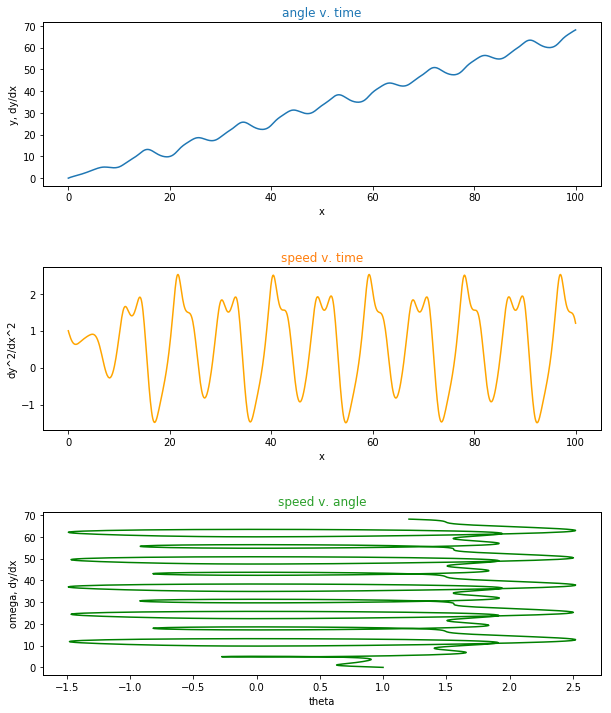

In [23]:
f, axarr = plt.subplots(3,1, figsize=(10,12))

axarr[0].plot(x, y[:,0], '-', label='y(x)')

axarr[0].set_xlabel('x')
axarr[0].set_ylabel('y, dy/dx')
axarr[0].set_title('angle v. time', color='C0')
axarr[0].axis()
#axarr[0].set_aspect(100)

axarr[1].plot(x, y[:,1], '-', color='orange', label='dydx(x)')
axarr[1].set_xlabel('x')
axarr[1].set_ylabel('dy^2/dx^2')
axarr[1].set_title('speed v. time', color='C1')

axarr[2].plot(y[:,1], y[:,0], '-', color='green', label='omega(theta)')

axarr[2].set_xlabel('theta')
axarr[2].set_ylabel('omega, dy/dx')
axarr[2].set_title('speed v. angle', color='C2')

f.subplots_adjust(wspace = 1.0)
#fig = plt.figure(figsize = (6,6))

'''Aesthetic edits to the plots'''

#change plots border width
plt.rcParams['axes.linewidth'] = 1 #set the value globally
#change distance between plots
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

### Plot the error

Notice that the errors will actually exceed our "tolerance".

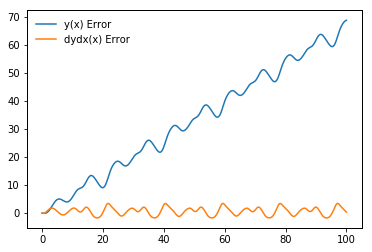

In [24]:
sine = np.sin(x)
cosine = np.cos(x)

y_error = (y[:,0] - sine)
dydx_error = (y[:,1] - cosine)

plt.plot(x, y_error, label='y(x) Error')
plt.plot(x, dydx_error, label="dydx(x) Error")
plt.legend(frameon=False)